<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
!pip install transformers --quiet
!pip install wget --quiet

In [103]:
import torch
from torch.utils.data import Dataset
class BertDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len=512):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    target = self.targets[idx]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [104]:
from tqdm import tqdm
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report


class BertClassifier:

    def __init__(self, path, n_classes=2):
        self.path = path
        self.model = BertForSequenceClassification.from_pretrained(path)
        self.tokenizer = BertTokenizer.from_pretrained(path)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.max_len = 64
        self.out_features = self.model.bert.encoder.layer[1].output.dense.out_features
        self.model.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.3), # 30% Probability
            torch.nn.Linear(self.out_features, n_classes)
        )
        
        self.model.to(self.device)

    
    def preparation(self, X_train, y_train, epochs):
        # create datasets
        self.train_set = BertDataset(X_train, y_train, self.tokenizer)
        # create data loaders
        self.train_loader = DataLoader(self.train_set, batch_size=8, shuffle=True)
        # helpers initialization
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=3e-5,
            eps = 1e-8,
            weight_decay=0.01,
            correct_bias=True
            )
        self.scheduler = get_linear_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=500,
                num_training_steps=len(self.train_loader) * epochs
            )
        self.loss_fn = torch.nn.CrossEntropyLoss().to(self.device)


    def fit(self):
        self.model = self.model.train()
        losses = []
        correct_predictions = 0

        for data in tqdm(self.train_loader):
            input_ids = data["input_ids"].to(self.device)
            attention_mask = data["attention_mask"].to(self.device)
            targets = data["targets"].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )

            preds = torch.argmax(outputs.logits, dim=1)
            loss = self.loss_fn(outputs.logits, targets)

            correct_predictions += torch.sum(preds == targets)

            losses.append(loss.item())
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()

        train_acc = correct_predictions.double() / len(self.train_set)
        train_loss = np.mean(losses)
        return train_acc, train_loss
    

    def train(self, X_train, y_train, X_valid, y_valid, X_test, y_test, epochs=5):
        print('*' * 10)
        print(f'Model: {self.path}')
        self.preparation(X_train, y_train, epochs)
        for epoch in range(epochs):
            print(f'Epoch {epoch + 1}/{epochs}')
            train_acc, train_loss = self.fit()
            print(f'Train loss {train_loss} accuracy {train_acc}')
            predictions_valid = [self.predict(x) for x in X_valid]
            precision, recall, f1score = precision_recall_fscore_support(y_valid, predictions_valid, average='macro')[:3]
            print('Valid:')
            print('Accuracy:', score_to_percent(accuracy_score(y_valid, predictions_valid)))
            print("Recall:", score_to_percent(recall_score(y_valid, predictions_valid)))
            print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
            predictions_test = [self.predict(x) for x in X_test]
            precision, recall, f1score = precision_recall_fscore_support(y_test, predictions_test, average='macro')[:3]
            print('Test:')
            print('Accuracy:', score_to_percent(accuracy_score(y_test, predictions_test)))
            print("Recall:", score_to_percent(recall_score(y_test, predictions_test)))
            print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
            print('*'*21)
            print(classification_report(y_test, predictions_test,digits=4))
            print('Accuracy:', score_to_percent(accuracy_score(y_test, predictions_test)))
            print("Recall:", score_to_percent(recall_score(y_test, predictions_test)))
            print("Precision:",score_to_percent(precision_score(y_test, predictions_test)))
            print("F1-score:", score_to_percent(f1_score(y_test, predictions_test)), '\n')
            print('*' * 21)
            
            plot_cm(y_test,predictions_test)
        print('*' * 10)
    
    def predict(self, text):
        self.model = self.model.eval()
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        out = {
              'text': text,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten()
          }
        
        input_ids = out["input_ids"].to(self.device)
        attention_mask = out["attention_mask"].to(self.device)
        
        outputs = self.model(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )
        
        prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

        return prediction

In [105]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def score_to_percent(score):
    return str(round(score * 100, 2)) + ' %'

def plot_cm(labels, predictions, p=0.5):
  print(type(labels)) 
  print(type(predictions))   
  cm = confusion_matrix(labels, predictions)
  plt.rcParams.update({'font.size': 22})
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
#   print("Accuracy:", score_to_percent(accuracy_score(y_test, pred)))
#   print("Recall:", score_to_percent(recall_score(y_test, pred)))
#   print("Precision:",score_to_percent(precision_score(y_test, pred)))
#   print("F1-score:", score_to_percent(f1_score(y_test, pred)), '\n')  
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

In [106]:
import wget
import os
url = 'https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/data_cleaned_RU.csv'

PATH_CLEANED_DATASET = 'data_cleaned_RU.csv'
if not os.path.exists(PATH_CLEANED_DATASET):
    wget.download(url)

In [107]:
import pandas as pd
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

df = pd.read_csv(PATH_CLEANED_DATASET)
df=df.astype({'toxic': 'int64'})
sentences = df.comment.values
labels = df.toxic.values

X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=.2, random_state=42) # .15 .2
print(X_train.shape)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25, random_state=42) # .1764705882352941 .25
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(11529,)
(8646,)
(2883,)
(2883,)


Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

**********
Model: cointegrated/rubert-tiny
Epoch 1/7


100%|██████████| 1081/1081 [01:18<00:00, 13.75it/s]


Train loss 0.4429916490496556 accuracy 0.785912560721721
Valid:
Accuracy: 86.47 %
Recall: 84.51 %
precision: 0.8460987977215635, recall: 0.8599330753104337, f1score: 0.852011091830331
Test:
Accuracy: 87.93 %
Recall: 85.2 %
precision: 0.859345664896402, recall: 0.87222994648891, f1score: 0.8651040193270179
*********************
              precision    recall  f1-score   support

           0     0.9258    0.8925    0.9089      1944
           1     0.7929    0.8520    0.8214       939

    accuracy                         0.8793      2883
   macro avg     0.8593    0.8722    0.8651      2883
weighted avg     0.8825    0.8793    0.8804      2883

Accuracy: 87.93 %
Recall: 85.2 %
Precision: 79.29 %
F1-score: 82.14 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1735
False Positives:  209
False Negatives:  139
True Positives:  800
Epoch 2/7


100%|██████████| 1081/1081 [01:18<00:00, 13.78it/s]


Train loss 0.30473462081532393 accuracy 0.8901226000462642
Valid:
Accuracy: 88.1 %
Recall: 88.31 %
precision: 0.8631638328463904, recall: 0.8815279793581681, f1score: 0.8706103251984119
Test:
Accuracy: 88.52 %
Recall: 87.11 %
precision: 0.8652453669229236, recall: 0.8815574093795606, f1score: 0.8722976225381334
*********************
              precision    recall  f1-score   support

           0     0.9348    0.8920    0.9129      1944
           1     0.7957    0.8711    0.8317       939

    accuracy                         0.8852      2883
   macro avg     0.8652    0.8816    0.8723      2883
weighted avg     0.8895    0.8852    0.8864      2883

Accuracy: 88.52 %
Recall: 87.11 %
Precision: 79.57 %
F1-score: 83.17 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1734
False Positives:  210
False Negatives:  121
True Positives:  818
Epoch 3/7


100%|██████████| 1081/1081 [01:18<00:00, 13.80it/s]


Train loss 0.2522360249112337 accuracy 0.9189220448762434
Valid:
Accuracy: 88.59 %
Recall: 80.62 %
precision: 0.8761178512974965, recall: 0.8663892920496694, f1score: 0.870905147627755
Test:
Accuracy: 89.73 %
Recall: 80.62 %
precision: 0.8893293511034824, recall: 0.8737674042519623, f1score: 0.8808205174041528
*********************
              precision    recall  f1-score   support

           0     0.9095    0.9414    0.9252      1944
           1     0.8691    0.8062    0.8365       939

    accuracy                         0.8973      2883
   macro avg     0.8893    0.8738    0.8808      2883
weighted avg     0.8964    0.8973    0.8963      2883

Accuracy: 89.73 %
Recall: 80.62 %
Precision: 86.91 %
F1-score: 83.65 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1830
False Positives:  114
False Negatives:  182
True Positives:  757
Epoch 4/7


100%|██████████| 1081/1081 [01:18<00:00, 13.78it/s]


Train loss 0.21375843807348463 accuracy 0.9371963913948647
Valid:
Accuracy: 88.31 %
Recall: 86.46 %
precision: 0.8662273540362335, recall: 0.8785865183034994, f1score: 0.8716904938650352
Test:
Accuracy: 89.46 %
Recall: 87.54 %
precision: 0.876117345174116, recall: 0.8896029726922521, f1score: 0.882159832975326
*********************
              precision    recall  f1-score   support

           0     0.9376    0.9038    0.9204      1944
           1     0.8147    0.8754    0.8439       939

    accuracy                         0.8946      2883
   macro avg     0.8761    0.8896    0.8822      2883
weighted avg     0.8975    0.8946    0.8955      2883

Accuracy: 89.46 %
Recall: 87.54 %
Precision: 81.47 %
F1-score: 84.39 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1757
False Positives:  187
False Negatives:  117
True Positives:  822
Epoch 5/7


100%|██████████| 1081/1081 [01:18<00:00, 13.82it/s]


Train loss 0.17368459495382813 accuracy 0.9509599814943326
Valid:
Accuracy: 88.38 %
Recall: 88.1 %
precision: 0.866290041576943, recall: 0.8831228834059023, f1score: 0.8733003104244391
Test:
Accuracy: 89.35 %
Recall: 88.07 %
precision: 0.8745074770944645, recall: 0.8902077663392892, f1score: 0.8813819546866927
*********************
              precision    recall  f1-score   support

           0     0.9398    0.8997    0.9193      1944
           1     0.8092    0.8807    0.8434       939

    accuracy                         0.8935      2883
   macro avg     0.8745    0.8902    0.8814      2883
weighted avg     0.8973    0.8935    0.8946      2883

Accuracy: 89.35 %
Recall: 88.07 %
Precision: 80.92 %
F1-score: 84.34 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1749
False Positives:  195
False Negatives:  112
True Positives:  827
Epoch 6/7


100%|██████████| 1081/1081 [01:18<00:00, 13.76it/s]


Train loss 0.1540844104796386 accuracy 0.9590562109646079
Valid:
Accuracy: 87.96 %
Recall: 89.13 %
precision: 0.8615486044420055, recall: 0.8824858893726819, f1score: 0.8696526397463937
Test:
Accuracy: 89.18 %
Recall: 89.35 %
precision: 0.8718510962734597, recall: 0.8922251147135776, f1score: 0.8802944808789711
*********************
              precision    recall  f1-score   support

           0     0.9454    0.8909    0.9174      1944
           1     0.7983    0.8935    0.8432       939

    accuracy                         0.8918      2883
   macro avg     0.8719    0.8922    0.8803      2883
weighted avg     0.8975    0.8918    0.8932      2883

Accuracy: 89.18 %
Recall: 89.35 %
Precision: 79.83 %
F1-score: 84.32 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1732
False Positives:  212
False Negatives:  100
True Positives:  839
Epoch 7/7


100%|██████████| 1081/1081 [01:18<00:00, 13.77it/s]


Train loss 0.14088047529296358 accuracy 0.9626416840157298
Valid:
Accuracy: 88.8 %
Recall: 87.08 %
precision: 0.8715366936906649, recall: 0.8837598774391227, f1score: 0.8769648992653242
Test:
Accuracy: 89.42 %
Recall: 86.69 %
precision: 0.8763704514008348, recall: 0.8871435333096676, f1score: 0.8813210190750971
*********************
              precision    recall  f1-score   support

           0     0.9338    0.9074    0.9204      1944
           1     0.8189    0.8669    0.8422       939

    accuracy                         0.8942      2883
   macro avg     0.8764    0.8871    0.8813      2883
weighted avg     0.8964    0.8942    0.8950      2883

Accuracy: 89.42 %
Recall: 86.69 %
Precision: 81.89 %
F1-score: 84.22 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1764
False Positives:  180
False Negatives:  125
True Positives:  814
**********


('./trainer/tokenizer_config.json',
 './trainer/special_tokens_map.json',
 './trainer/vocab.txt',
 './trainer/added_tokens.json')

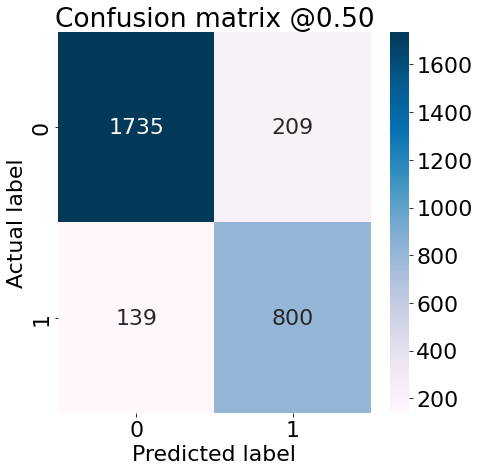

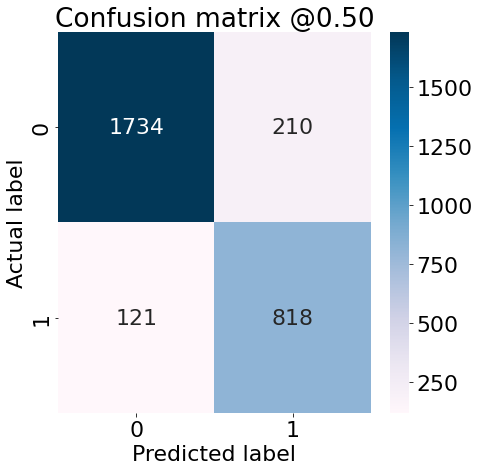

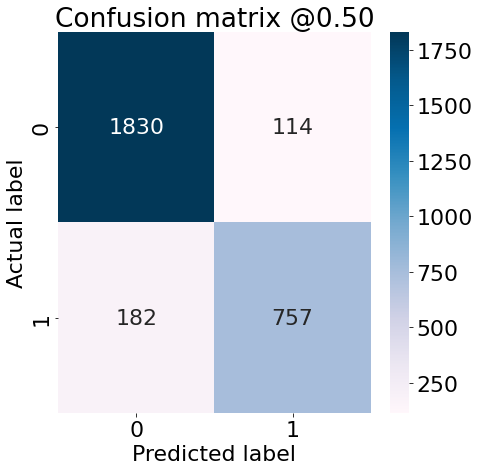

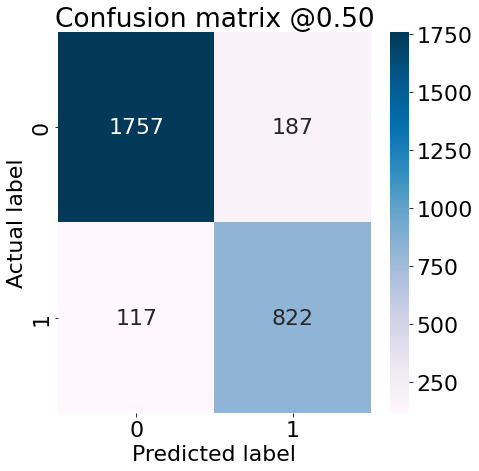

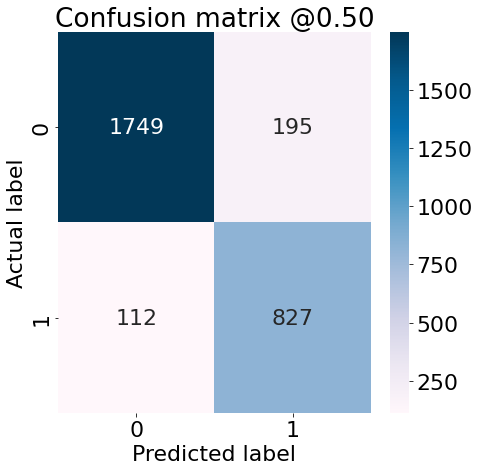

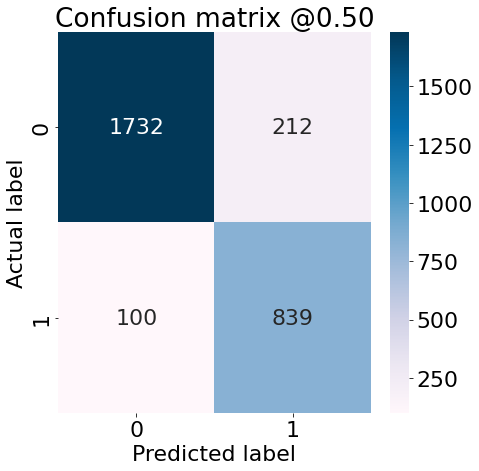

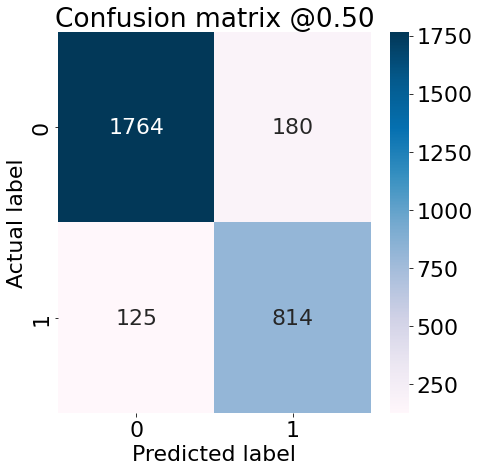

In [108]:
classifier = BertClassifier(
    path='cointegrated/rubert-tiny',
    n_classes=2
)

classifier.train(
        X_train=X_train,
        y_train=y_train,
        X_valid=X_val,
        y_valid=y_val,
        X_test=X_test,
        y_test=y_test,
        epochs=7
)

path = './trainer'
classifier.model.save_pretrained(path)
classifier.tokenizer.save_pretrained(path)